In [1]:
import numpy as np
import pandas as pd
import scipy as scipy
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df = pd.read_csv("C:\\Users\\Peter\\Desktop\\Prep Captstone\\Obamacare\\states.csv", low_memory = False) 
statepops = pd.read_csv("C:\\Users\\Peter\\Desktop\\Prep Captstone\\Obamacare\\statepops.csv", low_memory = False) 
stategdppercap = pd.read_csv("C:\\Users\\Peter\\Desktop\\Prep Captstone\\Obamacare\\StatesGDPpercapita.csv", low_memory = False)
statemedianinc = pd.read_csv("C:\\Users\\Peter\\Desktop\\Prep Captstone\\Obamacare\\Median Income  2014.csv", low_memory = False)

In [2]:
#The csv files are formated with some unneeded spacing around the state names so we have to standardize them

#strip spaces around the state names in state gdp per capita dataframe
df['State']=df['State'].str.strip()
#strip spaces around the state names in state gdp per capita dataframe
stategdppercap['State']=stategdppercap['State'].str.strip()
#strip spaces around the state names in state median income dataframe
statemedianinc['State']=statemedianinc['State'].str.strip()
#strips spaces around names from dataframe of state populations
statepops['State']=statepops['State'].str.strip() 

In [3]:
df.head()

,State,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Average Monthly Tax Credit (2016),State Medicaid Expansion (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
0,Alabama,14.6%,10.1%,-4.5%,215000,2545000,165534,152206,$310,False,799176.0,910775,111599.0,989855
1,Alaska,19.9%,14.9%,-5%,36000,390000,17995,16205,$750,True,122334.0,166625,44291.0,88966
2,Arizona,16.9%,10.8%,-6.1%,410000,3288000,179445,124346,$230,True,1201770.0,1716198,514428.0,1175624
3,Arkansas,17.5%,9.5%,-8%,234000,1365000,63357,56843,$306,True,556851.0,920194,363343.0,606146
4,California,18.5%,8.6%,-9.9%,3826000,19552000,1415428,1239893,$309,True,7755381.0,11843081,4087700.0,5829777


In [4]:
%timeit 
df.isnull().values.sum()

5

In [5]:
print(100 * df.isnull().sum()/len(df))#identify columns in data that are null

State                                           0.000000
Uninsured Rate (2010)                           0.000000
Uninsured Rate (2015)                           0.000000
Uninsured Rate Change (2010-2015)               0.000000
Health Insurance Coverage Change (2010-2015)    0.000000
Employer Health Insurance Coverage (2015)       0.000000
Marketplace Health Insurance Coverage (2016)    0.000000
Marketplace Tax Credits (2016)                  0.000000
Average Monthly Tax Credit (2016)               0.000000
State Medicaid Expansion (2016)                 1.923077
Medicaid Enrollment (2013)                      3.846154
Medicaid Enrollment (2016)                      0.000000
Medicaid Enrollment Change (2013-2016)          3.846154
Medicare Enrollment (2016)                      0.000000
dtype: float64


In [6]:
#multiply average monthly tax credit by number of tax credits issued by 12 (for 12 months to 1 year)
df['Total Marketplace Cost (2016)']=df['Marketplace Tax Credits (2016)']*df['Average Monthly Tax Credit (2016)'].str.lstrip('$').astype(int)*12

In [7]:
#create a new dataframe with just statename and overall annual cost of obamacare
costperstate = df.filter(['State', 'Total Marketplace Cost (2016)']) 

#drop the overall US from the dataframe
costperstate = costperstate.drop(costperstate[costperstate.State == 'United States'].index)

In [8]:
statepops = statepops.sort_values(['State'], ascending=[True])
#add state populations to the dataframe
addpop =  pd.merge(costperstate, statepops, left_on='State', right_on='State', how = "outer")

In [9]:
addpop['Per Capita Cost to the State of Obamacare 2016']=(addpop['Total Marketplace Cost (2016)']/addpop['Population estimate, July 1, 2016']).apply(np.int64)  

In [10]:
#drop the united states as a row from the dataframe prior to merging
stategdppercap = stategdppercap.drop(stategdppercap[stategdppercap.State == 'United States'].index)

#merge per capita gdp into dataframe
addgdppercap = pd.merge(addpop, stategdppercap, on='State')

#reanames the Per capita GDP column to be more informative
addgdppercap.rename(columns={'2015': 'Per Capita GPD (2015)'}, inplace=True)

In [11]:
#reanames the median income column to be more informative
statemedianinc.rename(columns={'2014': 'Median Income (2014)'}, inplace=True)

#drop Guam and the US from the median income dataframe
statemedianinc = statemedianinc.drop(statemedianinc[statemedianinc.State == 'United States'].index)
statemedianinc = statemedianinc.drop(statemedianinc[statemedianinc.State == 'Guam'].index)

#merge in median income into dataframe
addmedian = pd.merge(addgdppercap,statemedianinc,on='State')
data  = addmedian

In [14]:
list(data)

['State',
 'Total Marketplace Cost (2016)',
 'Population estimate, July 1, 2016',
 'Per Capita Cost to the State of Obamacare 2016',
 'Per Capita GPD (2015)',
 'Median Income (2014)']

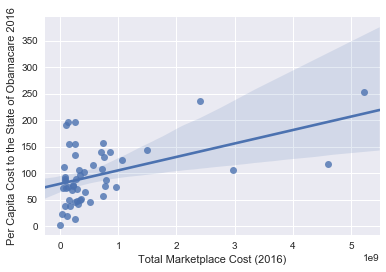

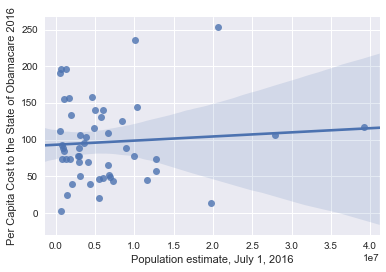

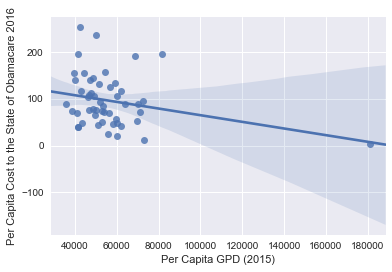

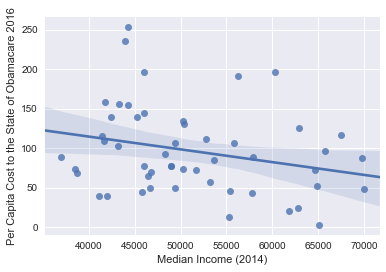

In [45]:
sns.regplot(data['Total Marketplace Cost (2016)'], data['Per Capita Cost to the State of Obamacare 2016'])
plt.show()
sns.regplot(data['Population estimate, July 1, 2016'], data['Per Capita Cost to the State of Obamacare 2016'])
plt.show()
sns.regplot(data['Per Capita GPD (2015)'], data['Per Capita Cost to the State of Obamacare 2016'])
plt.show()
sns.regplot(data['Median Income (2014)'], data['Per Capita Cost to the State of Obamacare 2016'])
plt.show()

In [19]:
from sklearn import linear_model
X = data[['Total Marketplace Cost (2016)', 'Population estimate, July 1, 2016', 'Per Capita GPD (2015)', 'Median Income (2014)']]
Y = data['Per Capita Cost to the State of Obamacare 2016']
regr = linear_model.LinearRegression()
regr.fit(X,Y)
Y_ = regr.predict(X)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [  6.67736427e-08  -7.27402984e-06  -3.72703638e-04  -2.82973973e-04]

Intercept: 
 134.915884891

R-squared:
0.571325259016


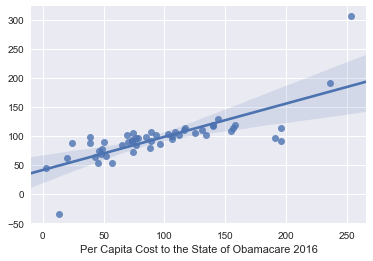

In [40]:
sns.regplot(Y, Y_)


In [69]:
from sklearn.preprocessing import normalize
normedX = normalize(X)

from sklearn import neighbors
KNN = KNeighborsRegressor(n_neighbors=5, weights = 'distance')
KNN.fit(normedX, Y)

from sklearn.model_selection import cross_val_score
score = cross_val_score(KNN, X, Y, cv=5)
print("Erroe: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Erroe: -0.54 (+/- 1.24)
